In [21]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer

import utils
np.random.seed(9112005)
np.set_printoptions(precision=5)

In [22]:
# consider 3 qubits
N   = 3
bound = 1


psi_0 = np.ones(2 ** N)
psi_0 /= np.linalg.norm(psi_0)

In [23]:
M_max    = 4
M_values = np.arange(1, M_max + 1)
N_h = 4

data = []

for _ in tqdm(range(N_h)):
    H = utils.get_random_H(N, bound)
    v, w = eigh(H)
    w = w.T
    
    gs = w[0]
    v_max = np.max(np.abs(v))

    fsp_i = np.abs(np.vdot(gs, psi_0)) ** 2

    for M in M_values:
        n_anc = 2 * M
        t = M / (2 * v_max) # moving along the straight line in the heatmap

        qc = utils.get_itimevol_circuit(N, M, H, t, psi_0)
        qc.save_statevector()

        aer_sim = Aer.get_backend("aer_simulator_statevector")
        qc_tp   = transpile(qc, backend=aer_sim)
        result  = aer_sim.run(qc_tp, shots=1).result()

        final_state_dict     = result.get_statevector(qc_tp).to_dict()
        final_state_sys_dict = {}

        for k, v in final_state_dict.items():
            if k[-n_anc:] == '0' * n_anc:
                k_new = k[:N]
                final_state_sys_dict[k_new] = v

        final_state_sys_list = [(k, v) for k, v in final_state_sys_dict.items()]
        final_state_sys_list = sorted(final_state_sys_list)
        final_state          = np.array([t[1] for t in final_state_sys_list])
        final_state          /= np.linalg.norm(final_state)

        fsp_f = np.abs(np.vdot(gs, final_state)) ** 2
        # print(f"fsp_i = {fsp_i:.5f}     M = {M}     fsp_f = {fsp_f:.5f}")
        data.append((fsp_i, M, fsp_f))

100%|██████████| 4/4 [00:35<00:00,  8.89s/it]


       fsp_i  M     fsp_f
0   0.346659  1  0.559671
1   0.346659  2  0.718307
2   0.346659  3  0.814058
3   0.346659  4  0.870578
4   0.213658  1  0.531649
5   0.213658  2  0.802481
6   0.213658  3  0.922262
7   0.213658  4  0.965535
8   0.175044  1  0.281338
9   0.175044  2  0.384377
10  0.175044  3  0.474492
11  0.175044  4  0.550629
12  0.003020  1  0.009357
13  0.003020  2  0.021369
14  0.003020  3  0.037851
15  0.003020  4  0.057200


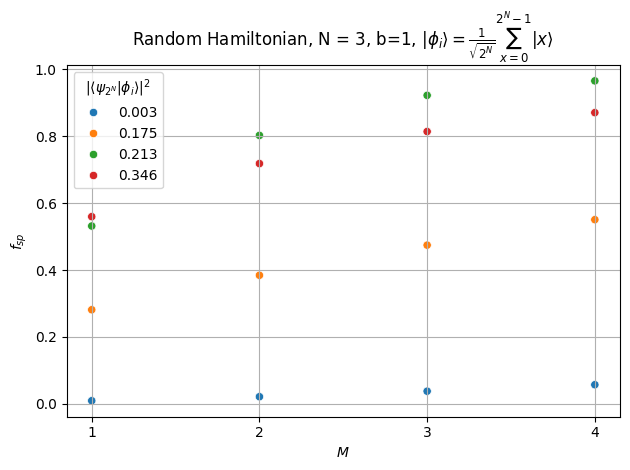

In [28]:
df = pd.DataFrame(data, columns=["fsp_i", "M", "fsp_f"])
print(df)
plot = sns.scatterplot(df, x = "M", y = "fsp_f", hue = "fsp_i", palette="tab10")
plt.xlabel(r'$M$')
plt.ylabel(r'$f_{sp}$')
plt.title(rf"Random Hamiltonian, N = {N}, b={bound}, $|\phi_i\rangle = \frac{{1}}{{\sqrt{{2^N}}}} \sum_{{x=0}}^{{2^N-1}} |{{x}}\rangle$")
plt.tight_layout()
plt.grid()

# fix legend
leg = plot.legend()
leg.set_title(r"$|\langle \psi_{{2^N}} | \phi_i \rangle|^2$")
for t in leg.get_texts():
    foo = t.get_text()
    t.set_text(foo[:5])

# fix xticks
plot.set_xticks(M_values);